In [78]:
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from evaluate import evaluate_holdout

In [79]:
# Загрузка предобработанных данных
root = "../.."
input_path = f"{root}/data/processed"

scaled_droplet_size_data = pd.read_csv(f"{input_path}/scaled/droplet_size.csv")
encoded_droplet_size_data  = pd.read_csv(f"{input_path}/encoded/droplet_size.csv")
catboost_droplet_size_data = pd.read_csv(f"{input_path}/catboost/droplet_size.csv")

In [80]:
# Разделение признаков и целевой переменной
X_scaled = scaled_droplet_size_data.drop(columns=["experiment.results.droplet_size.value"])
y_scaled = scaled_droplet_size_data["experiment.results.droplet_size.value"]

X_encoded  = encoded_droplet_size_data .drop(columns=["experiment.results.droplet_size.value"])
y_encoded  = encoded_droplet_size_data ["experiment.results.droplet_size.value"]

X_catboost = catboost_droplet_size_data.drop(columns=["experiment.results.droplet_size.value"])
y_catboost = catboost_droplet_size_data["experiment.results.droplet_size.value"]

# Выделение категориальных признаков для CatBoost
catboost_features = X_catboost.select_dtypes(include=["object", "category"]).columns.tolist()
X_catboost[catboost_features] = X_catboost[catboost_features].fillna('nan')

results = {}

In [81]:
# Достаём scale и mean для обратного преобразования
df = pd.read_csv(f"{input_path}/scaled/full.csv")
column_name = "experiment.results.droplet_size.value"
column_index = df.columns.get_loc(column_name)

scaler = joblib.load(f"{input_path}/scaled/std_scaler.joblib")
scale = scaler.scale_[column_index]
mean = scaler.mean_[column_index]

In [82]:
# Разделение данных на тренеровочную и тестовую выборки
TEST_SIZE = 0.2
GROUPS_SIZE = 10
# 109
RANDOM_STATE = 109#np.random.randint(0, 1000)
num_groups = len(X_scaled) // GROUPS_SIZE

# SVR, MLR
X_groups_scaled = np.array_split(X_scaled, num_groups)
y_groups_scaled = np.array_split(y_scaled, num_groups)

X_groups_scaled_train, X_groups_scaled_test, y_groups_scaled_train, y_groups_scaled_test = train_test_split(
    X_groups_scaled, y_groups_scaled, test_size = TEST_SIZE, random_state = RANDOM_STATE
)

X_scaled_train = pd.concat(X_groups_scaled_train, ignore_index=True)
X_scaled_test = pd.concat(X_groups_scaled_test, ignore_index=True)
y_scaled_train = pd.concat(y_groups_scaled_train, ignore_index=True)
y_scaled_test = pd.concat(y_groups_scaled_test, ignore_index=True)

# RF, GBR, XGBoost
X_groups_encoded = np.array_split(X_encoded, num_groups)
y_groups_encoded = np.array_split(y_encoded, num_groups)

X_groups_encoded_train, X_groups_encoded_test, y_groups_encoded_train, y_groups_encoded_test = train_test_split(
    X_groups_encoded, y_groups_encoded, test_size = TEST_SIZE, random_state = RANDOM_STATE
)

X_encoded_train = pd.concat(X_groups_encoded_train, ignore_index=True)
X_encoded_test = pd.concat(X_groups_encoded_test, ignore_index=True)
y_encoded_train = pd.concat(y_groups_encoded_train, ignore_index=True)
y_encoded_test = pd.concat(y_groups_encoded_test, ignore_index=True)


# CatBoost
X_groups_catboost = np.array_split(X_catboost, num_groups)
y_groups_catboost = np.array_split(y_catboost, num_groups)

X_groups_catboost_train, X_groups_catboost_test, y_groups_catboost_train, y_groups_catboost_test = train_test_split(
    X_groups_catboost, y_groups_catboost, test_size = TEST_SIZE, random_state = RANDOM_STATE
)

X_catboost_train = pd.concat(X_groups_catboost_train, ignore_index=True)
X_catboost_test = pd.concat(X_groups_catboost_test, ignore_index=True)
y_catboost_train = pd.concat(y_groups_catboost_train, ignore_index=True)
y_catboost_test = pd.concat(y_groups_catboost_test, ignore_index=True)
RANDOM_STATE

p:\GitHub\Darknessich\UASSML\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
p:\GitHub\Darknessich\UASSML\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


109

In [83]:
groups_ids = np.repeat(np.arange(len(X_scaled_train) // GROUPS_SIZE), GROUPS_SIZE)
# Кросс-валидация
cv = GroupKFold(n_splits=10, shuffle=True, random_state=0)

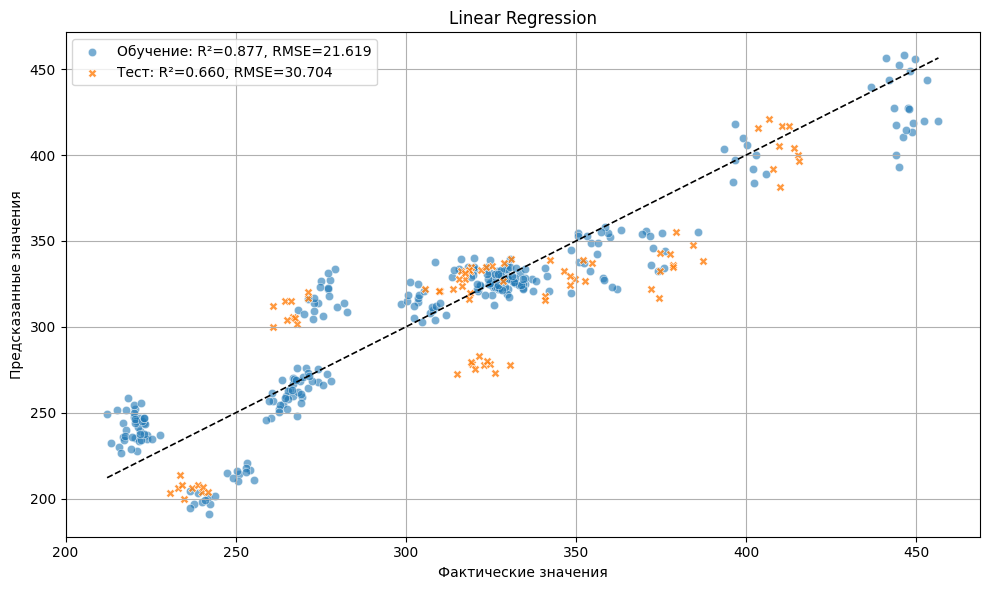

In [84]:
results["LinearRegression"] = evaluate_holdout(
    X_scaled_train, X_scaled_test, 
    y_scaled_train, y_scaled_test, 
    LinearRegression(), "Linear Regression",
    scale=scale, mean=mean
)

In [85]:
# Подбор гиперпараметров для SVR
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': np.logspace(-2, 3, 6),        # 0.01, 0.1, 1, 10, 100, 1000
    'epsilon': np.logspace(-3, -1, 3), # 0.001, 0.01, 0.1
    'gamma': ['scale']
}

# Grid Search
grid_search = GridSearchCV(SVR(), param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=3)
grid_search.fit(X_scaled_train, y_scaled_train, groups=groups_ids)

# Результаты
print("Best parameters:", grid_search.best_params_)
print("Best R2 score (KFold):", grid_search.best_score_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Best parameters: {'C': np.float64(1.0), 'epsilon': np.float64(0.001), 'gamma': 'scale', 'kernel': 'poly'}
Best R2 score (KFold): -1.2959965497500652


In [86]:
# Подбор гиперпараметров для SVR
kernel = grid_search.best_params_['kernel']
gamma = grid_search.best_params_['gamma']
lgC = np.log10(grid_search.best_params_['C'])
lge = np.log10(grid_search.best_params_['epsilon'])

param_grid = {
    'kernel': [kernel], 
    'C': np.logspace(lgC - 1, lgC + 1, 40),        
    'epsilon': np.logspace(lge - 1, lge + 1, 40),
    'gamma': [gamma]
}

# Grid Search
grid_search = GridSearchCV(SVR(), param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_scaled_train, y_scaled_train, groups=groups_ids)

# Результаты
print("Best parameters:", grid_search.best_params_)
print("Best R2 score (KFold):", grid_search.best_score_)

Fitting 10 folds for each of 1600 candidates, totalling 16000 fits
Best parameters: {'C': np.float64(0.3665241237079628), 'epsilon': np.float64(0.0007443803013251688), 'gamma': 'scale', 'kernel': 'poly'}
Best R2 score (KFold): -1.050127382020755


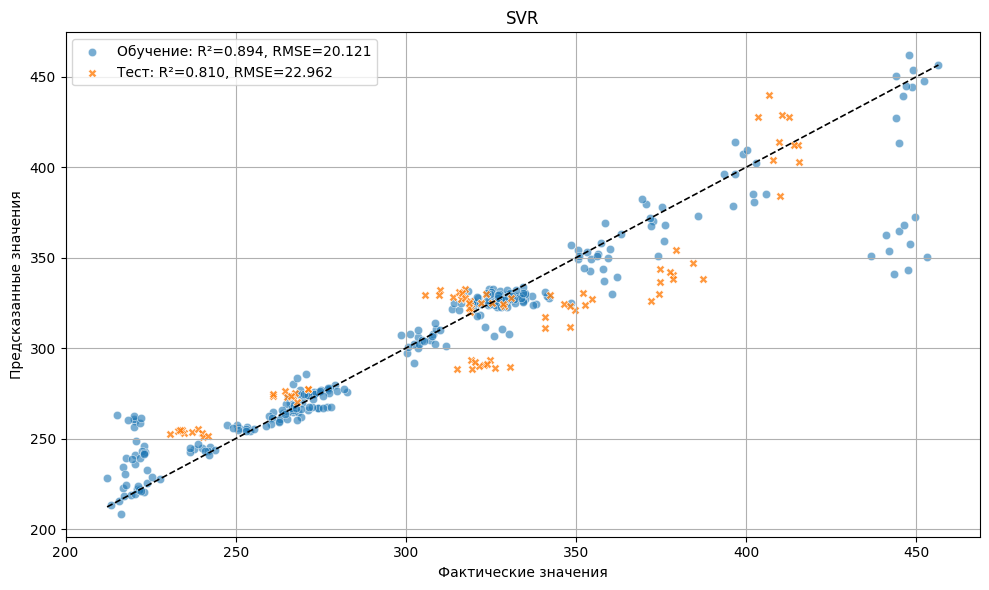

In [87]:
results["SVR"] = evaluate_holdout(
    X_scaled_train, X_scaled_test, 
    y_scaled_train, y_scaled_test,
    SVR(**grid_search.best_params_), "SVR",
    scale=scale, mean=mean
)

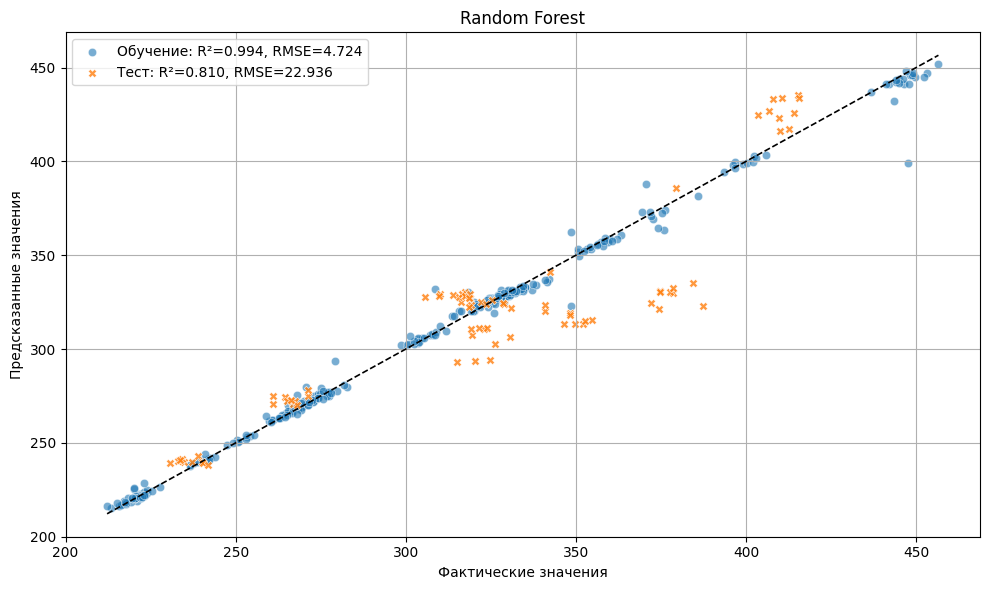

In [88]:
results["RandomForest"] = evaluate_holdout(
    X_encoded_train, X_encoded_test,
    y_encoded_train, y_encoded_test,
    RandomForestRegressor(), "Random Forest"
)

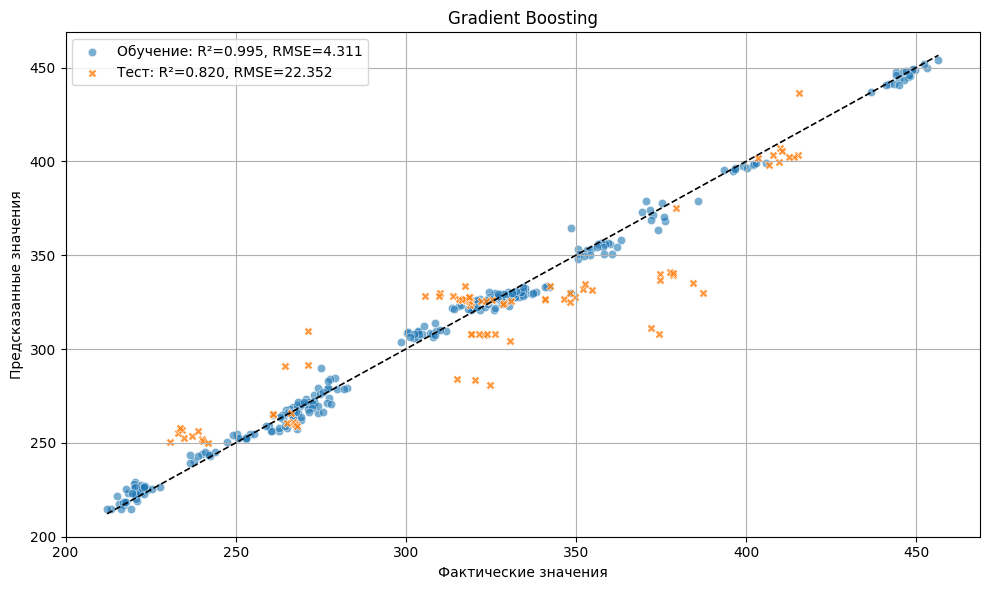

In [89]:
results["GradientBoosting"] = evaluate_holdout(
    X_encoded_train, X_encoded_test,
    y_encoded_train, y_encoded_test,
    GradientBoostingRegressor(), "Gradient Boosting"
)

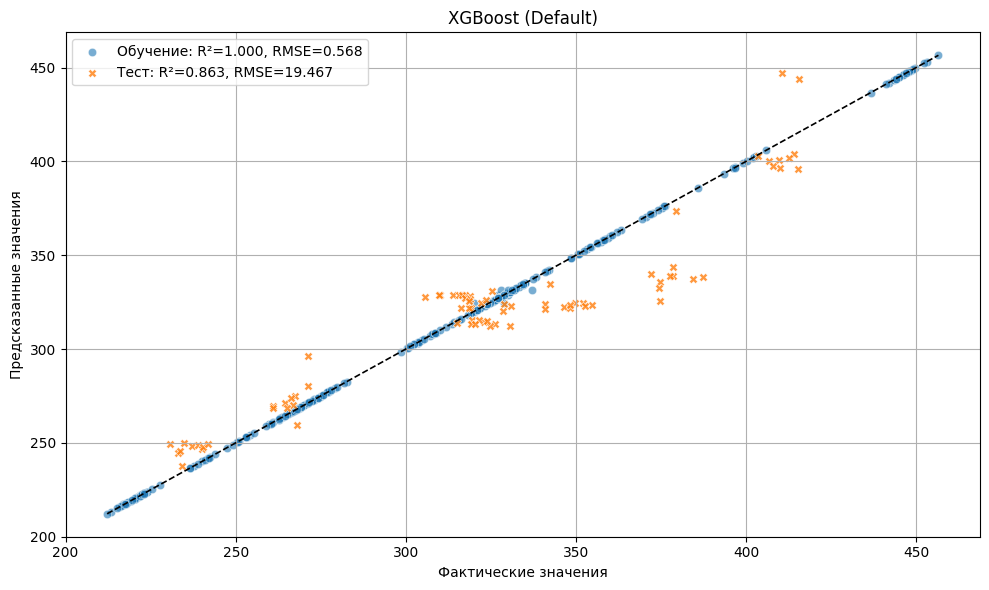

In [95]:
results["XGBoost (Default)"] = evaluate_holdout(
    X_encoded_train, X_encoded_test,
    y_encoded_train, y_encoded_test,
    XGBRegressor(), "XGBoost (Default)"
)

In [91]:
# Параметры для подбора XGBoost
param_grid = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 10),
    'learning_rate': Continuous(0.01, 0.3),
    'subsample': Continuous(0.5, 1.0),
    'colsample_bytree': Continuous(0.5, 1.0),
    'gamma': Continuous(0, 5),
    'reg_alpha': Continuous(0, 2),
    'reg_lambda': Continuous(0, 2),
}

cv_splits = list(cv.split(X_encoded_train, y_encoded_train, groups=groups_ids))

# Генетический поиск
evolved_search = GASearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', tree_method='auto', random_state=0),
    cv=cv_splits,
    scoring='r2',
    param_grid=param_grid,
    population_size=30,
    generations=20,
    n_jobs=-1,
    verbose=True,
    error_score='raise'
)

# Обучение
evolved_search.fit(X_encoded_train, y_encoded_train)

# Лучшие параметры
print("Best parameters:", evolved_search.best_params_)
print("Best R2 score (CV):", evolved_search.best_score_)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	30    	-1.16022	0.720277   	-0.293853  	-3.54633   
1  	60    	-0.812243	0.40132    	-0.293853  	-1.91115   
2  	60    	-0.553092	0.14334    	-0.293853  	-0.967258  
3  	60    	-0.431217	0.0941101  	-0.290901  	-0.720854  
4  	60    	-0.383901	0.0995352  	-0.158222  	-0.601048  
5  	60    	-0.360221	0.0815078  	-0.252373  	-0.585955  
6  	60    	-0.329022	0.0474471  	-0.266743  	-0.469495  
7  	60    	-0.318382	0.0590252  	-0.237785  	-0.509853  
8  	60    	-0.276506	0.0584273  	-0.19454   	-0.482702  
9  	60    	-0.232573	0.0485709  	-0.189897  	-0.420922  
10 	60    	-0.222157	0.0443218  	-0.175113  	-0.420922  
11 	60    	-0.194063	0.0234501  	-0.159107  	-0.26859   
12 	60    	-0.17535 	0.0231071  	-0.0985429 	-0.236494  
13 	60    	-0.159005	0.0268063  	-0.102633  	-0.236494  
14 	60    	-0.146915	0.0236788  	-0.101412  	-0.182467  
15 	60    	-0.125183	0.0215324  	-0.0844207 	-0.167347  
16 	60    	-0.127468	0.0193877  	

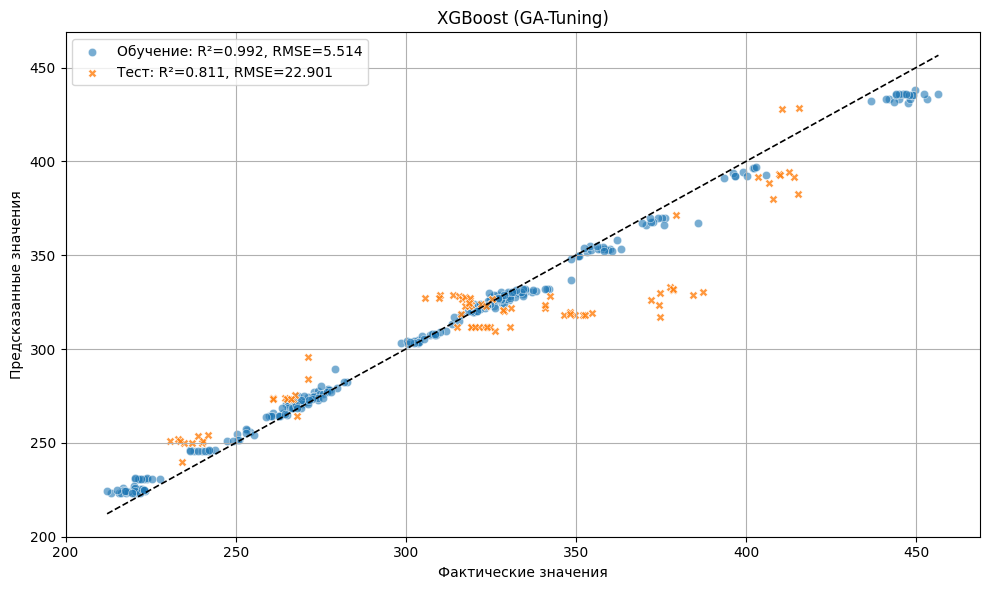

In [96]:
results["XGBoost (GA-Tuning)"] = evaluate_holdout(
    X_encoded_train, X_encoded_test,
    y_encoded_train, y_encoded_test,
    XGBRegressor(**evolved_search.best_params_), "XGBoost (GA-Tuning)"
)

Learning rate set to 0.033483
0:	learn: 60.5677885	total: 26.1ms	remaining: 26s
1:	learn: 59.2671968	total: 51.9ms	remaining: 25.9s
2:	learn: 58.2081335	total: 82.4ms	remaining: 27.4s
3:	learn: 56.8873050	total: 114ms	remaining: 28.5s
4:	learn: 55.6248554	total: 144ms	remaining: 28.6s
5:	learn: 54.5285684	total: 174ms	remaining: 28.8s
6:	learn: 53.5183501	total: 192ms	remaining: 27.3s
7:	learn: 52.5496495	total: 222ms	remaining: 27.5s
8:	learn: 51.6741290	total: 254ms	remaining: 28s
9:	learn: 50.7029298	total: 284ms	remaining: 28.1s
10:	learn: 49.8863978	total: 313ms	remaining: 28.2s
11:	learn: 49.0358946	total: 343ms	remaining: 28.3s
12:	learn: 48.4703425	total: 374ms	remaining: 28.4s
13:	learn: 47.7415618	total: 393ms	remaining: 27.7s
14:	learn: 46.9131107	total: 423ms	remaining: 27.8s
15:	learn: 46.2300674	total: 454ms	remaining: 27.9s
16:	learn: 45.3891477	total: 484ms	remaining: 28s
17:	learn: 44.7870751	total: 508ms	remaining: 27.7s
18:	learn: 43.9542706	total: 538ms	remaining: 2

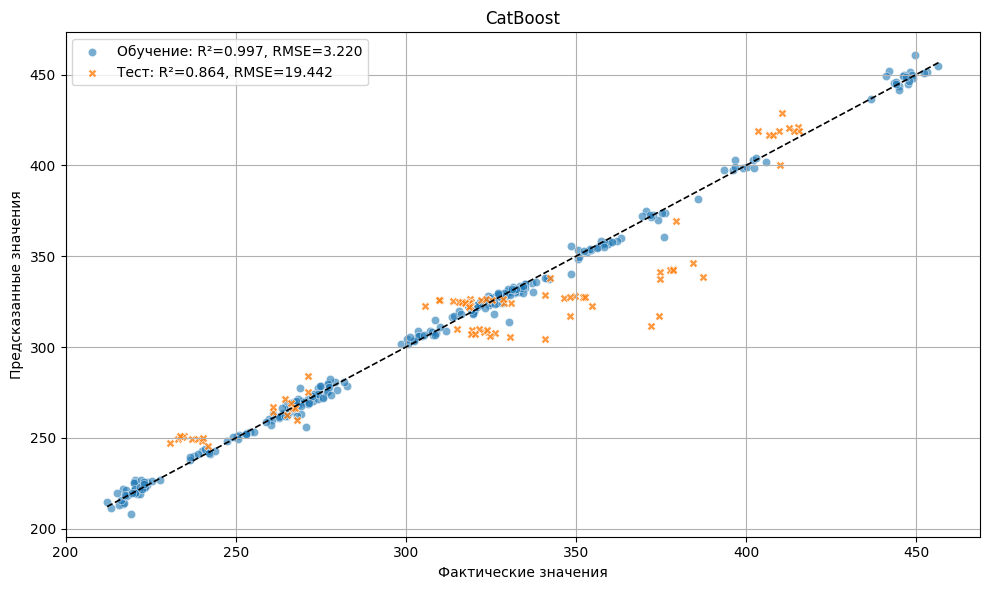

In [93]:
results["CatBoost"] = evaluate_holdout(
    X_catboost_train, X_catboost_test,
    y_catboost_train, y_catboost_test, 
    CatBoostRegressor(), "CatBoost",
    cat_features=catboost_features
)

In [94]:
results_df = pd.DataFrame(results)
results_df = results_df.T.reset_index().rename(columns={'index': 'Модель'})
results_df = results_df.sort_values("r2_test", ascending=False).reset_index(drop=True)
results_df = results_df.rename(columns={
    "model":      "Модель",
    "r2_train":   "R² обуч.",
    "rmse_train": "RMSE обуч.",
    "r2_test":    "R² тест.",
    "rmse_test":  "RMSE тест."
})

results_df

,Модель,R² обуч.,RMSE обуч.,R² тест.,RMSE тест.
0,CatBoost,0.997282,3.219687,0.863812,19.442279
1,XGBoost (Default),0.999915,0.568252,0.863462,19.467204
2,GradientBoosting,0.995127,4.311346,0.820001,22.351813
3,XGBoost (GA-Tuning),0.992029,5.513798,0.811052,22.900683
4,RandomForest,0.994150,4.723604,0.810464,22.936303
5,SVR,0.893861,20.120588,0.810034,22.962318
6,LinearRegression,0.877465,21.618812,0.660338,30.704413


In [105]:
# Важнейшие признаки CatBoost
model = CatBoostRegressor()
model.fit(X_catboost_train, y_catboost_train, cat_features=catboost_features, verbose=0)

importances = model.get_feature_importance()
feature_names = X_catboost_train.columns
for name, importance in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {importance:.1f}")

experiment.params.spray_volume: 55.4
experiment.params.atomization_diameter: 13.3
experiment.params.height: 4.4
model.rotors.power: 4.0
experiment.params.flight_speed: 2.7
model.nozzles.number: 2.4
plant.name: 2.0
model.particle_diameter.max: 1.8
model.particle_diameter.min: 1.7
model.water_pump.number: 1.5
model.weight: 1.2
experiment.weather.velocity.min: 1.1
model.dimensions.length: 0.9
model.water_pump.flow_rate: 0.8
plant.phenotypes.height: 0.7
experiment.weather.velocity.max: 0.7
experiment.weather.temperature.max: 0.7
model.rotors.number: 0.7
experiment.params.flow_rate: 0.6
model.swath_width.max: 0.5
experiment.weather.temperature.min: 0.5
experiment.weather.humidity.max: 0.4
experiment.weather.humidity.min: 0.4
model.water_pump.type: 0.3
model.dimensions.height: 0.3
model.swath_width.min: 0.2
plant.phenotypes.orthotropic_branch_node_number: 0.2
model.nozzles.type: 0.1
plant.phenotypes.orthotropic_branch_length: 0.1
plant.phenotypes.plagiotropic_node_number: 0.1
model.tank_volu

In [104]:
# Важнейшие признаки GradientBoosting
model = GradientBoostingRegressor()
model.fit(X_encoded_train, y_encoded_train)

importances = model.feature_importances_
feature_names = X_encoded_train.columns
for name, importance in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {importance*100:.1f}")

experiment.params.spray_volume: 57.1
experiment.params.atomization_diameter_coarse: 10.5
experiment.weather.velocity.min: 7.6
experiment.params.atomization_diameter_fine: 6.2
model.tank_volume: 5.7
experiment.params.height: 3.3
experiment.params.flight_speed: 2.2
plant.name_tea: 1.9
experiment.weather.velocity.max: 1.4
model.name_AGRAS T40: 0.8
model.nozzles.type_SX11001VS: 0.7
model.nozzles.number: 0.5
model.nozzles.type_LX8060SZ: 0.5
experiment.weather.temperature.max: 0.3
experiment.weather.humidity.min: 0.3
model.rotors.number: 0.3
experiment.params.atomization_diameter_off: 0.3
experiment.weather.humidity.max: 0.2
experiment.params.atomization_diameter_medium: 0.2
experiment.weather.temperature.min: 0.0
model.nozzles.type_XR110015: 0.0
plant.name_coffee: 0.0
plant.name_wheat: 0.0
model.name_AGRAS T20: 0.0
model.name_AGRAS T30: 0.0
model.name_JT5L-404: 0.0
model.nozzles.type_full cone: 0.0


In [103]:
# Важнейшие признаки XGBoost (Default)
model = XGBRegressor()
model.fit(X_encoded_train, y_encoded_train)

importances = model.feature_importances_
feature_names = X_encoded_train.columns
for name, importance in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {importance*100:.1f}")

experiment.params.atomization_diameter_fine: 35.4
model.tank_volume: 25.7
experiment.params.atomization_diameter_coarse: 24.3
experiment.params.spray_volume: 13.0
experiment.params.height: 0.6
experiment.weather.velocity.min: 0.4
experiment.params.flight_speed: 0.3
experiment.weather.humidity.max: 0.1
experiment.weather.temperature.max: 0.1
experiment.params.atomization_diameter_medium: 0.0
experiment.weather.velocity.max: 0.0
experiment.weather.temperature.min: 0.0
experiment.weather.humidity.min: 0.0
model.nozzles.number: 0.0
model.rotors.number: 0.0
plant.name_coffee: 0.0
plant.name_tea: 0.0
plant.name_wheat: 0.0
model.name_AGRAS T20: 0.0
model.name_AGRAS T30: 0.0
model.name_AGRAS T40: 0.0
model.name_JT5L-404: 0.0
model.nozzles.type_LX8060SZ: 0.0
model.nozzles.type_SX11001VS: 0.0
model.nozzles.type_XR110015: 0.0
model.nozzles.type_full cone: 0.0
experiment.params.atomization_diameter_off: 0.0
